# Divvy Bike Ride Prediction

### Introduction

### Importing Libraries and Data

In [63]:
import os
import math
import random
import subprocess

import numpy   as np
import pandas  as pd
import seaborn as sns
import matplotlib.pyplot as plt
import dask.dataframe as dd

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

from tqdm import tqdm

pd.set_option('mode.chained_assignment', None)

In [64]:
%%time

filename = "data/data.csv"

def file_len(fname):
    p = subprocess.Popen(['wc', '-l', fname], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    result, err = p.communicate()
    if p.returncode != 0:
        raise IOError(err)
    return int(result.strip().split()[0]) + 1

n_rows = file_len(filename)
print('Data file contains {} rows'.format(n_rows))

Data file contains 9495237 rows
CPU times: user 2.24 ms, sys: 38 ms, total: 40.2 ms
Wall time: 1.76 s


In [67]:
traintypes = {
    'trip_id': 'int32',
    'year': 'uint16',
    'month': 'uint8',
    'week': 'uint8',
    'day': 'uint8',
    'hour': 'uint8',
    'usertype': 'str',
    'gender': 'str',
    'starttime': 'str',
    'stoptime': 'str',
    'tripduration': 'float32',
    'temperature': 'float32',
    'events': 'str',
    'from_station_id': 'int32',
    'from_station_name': 'str',
    'latitude_start': 'float32',
    'longitude_start': 'float32',
    'dpcapacity_start': 'float32',
    'to_station_id': 'int32',
    'to_station_name': 'str',
    'latitude_end': 'float32',
    'longitude_end': 'float32',
    'dpcapacity_end': 'float32'
}
cols = list(traintypes.keys())

In [68]:
chunksize = 1_000_000

In [69]:
%%time
df_list = []

for df_chunk in tqdm(
    pd.read_csv(
        filename, 
        usecols=cols, 
        dtype=traintypes, 
        chunksize=chunksize
    )
):
    df_chunk['starttime'] = df_chunk['starttime'].str.slice(0, 16)
    df_chunk['starttime'] = pd.to_datetime(df_chunk['starttime'], utc=True, format='%Y-%m-%d %H:%M')
    
    df_list.append(df_chunk)







0it [00:00, ?it/s]





1it [00:04,  4.58s/it]





2it [00:08,  4.27s/it]





3it [00:11,  4.00s/it]





4it [00:14,  3.81s/it]





5it [00:17,  3.61s/it]





6it [00:22,  3.86s/it]





7it [00:26,  4.04s/it]





8it [00:31,  4.23s/it]





9it [00:35,  4.22s/it]





10it [00:37,  3.75s/it]

CPU times: user 34.2 s, sys: 3.12 s, total: 37.3 s
Wall time: 37.5 s


In [70]:
data_df = pd.concat(df_list[0:1])

del df_list

data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 23 columns):
trip_id              1000000 non-null int32
year                 1000000 non-null uint16
month                1000000 non-null uint8
week                 1000000 non-null uint8
day                  1000000 non-null uint8
hour                 1000000 non-null uint8
usertype             1000000 non-null object
gender               1000000 non-null object
starttime            1000000 non-null datetime64[ns, UTC]
stoptime             1000000 non-null object
tripduration         1000000 non-null float32
temperature          1000000 non-null float32
events               1000000 non-null object
from_station_id      1000000 non-null int32
from_station_name    1000000 non-null object
latitude_start       1000000 non-null float32
longitude_start      1000000 non-null float32
dpcapacity_start     1000000 non-null float32
to_station_id        1000000 non-null int32
to_station_name      1

In [71]:
train_df, test_df = train_test_split(data_df, shuffle=True)

print('There are {} rows in the training dataset'.format(train_df.shape[0]))
print('There are {} rows in the testing dataset'.format(test_df.shape[0]))
print(train_df.describe())

There are 750000 rows in the training dataset
There are 250000 rows in the testing dataset
            trip_id      year          month           week            day  \
count  7.500000e+05  750000.0  750000.000000  750000.000000  750000.000000   
mean   2.283766e+06    2014.0       6.017533      24.808092       2.721869   
std    7.896542e+05       0.0       1.985677       8.751720       1.896548   
min    1.109427e+06    2014.0       1.000000       1.000000       0.000000   
25%    1.617561e+06    2014.0       5.000000      19.000000       1.000000   
50%    2.181207e+06    2014.0       6.000000      25.000000       3.000000   
75%    2.738112e+06    2014.0       7.000000      30.000000       4.000000   
max    3.810750e+06    2014.0       9.000000      40.000000       6.000000   

                hour   tripduration    temperature  from_station_id  \
count  750000.000000  750000.000000  750000.000000    750000.000000   
mean       13.845196      11.691577      64.019348       161.831

### Feature Engineering

I want to know, as Bird Scooter flies, how far each rider took their Divvy bike. Disclaimer: this will only give us the total displacement of a ride, so a user might have gone 20 miles round trip, but if they ended up back at the same station then they'll come across as going 0 with this method. It should be a useful metric specifically for people who are using the bike to commute.

We'll use the haversine formula to calculate the great circle distance in kilometers that a bike is displaced and then get average rate from that.

Finally we have to encode the gender and events columns to integers instead of being strings.

In [72]:
def haversine(row):
    
    lon1 = row['longitude_start']
    lat1 = row['latitude_start']
    lon2 = row['longitude_end']
    lat2 = row['latitude_end']
    
    lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])
    
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    
    km = 6367 * c
    
    return km

train_df['displacement'] = train_df.apply(lambda row: haversine(row), axis=1)
train_df['rate'] = train_df['displacement'].div(train_df['tripduration']).multiply(60)

test_df['displacement'] = test_df.apply(lambda row: haversine(row), axis=1)
test_df['rate'] = test_df['displacement'].div(test_df['tripduration']).multiply(60)

print('==TARGETS==')
print(train_df[['tripduration', 'displacement', 'rate']].describe())

==TARGETS==
        tripduration   displacement           rate
count  750000.000000  750000.000000  750000.000000
mean       11.691577       1.949732      10.137689
std         7.222957       1.394305       3.199500
min         2.000000       0.000000       0.000000
25%         6.233333       0.938211       8.259876
50%         9.933333       1.541446      10.207833
75%        15.566667       2.584813      12.218482
max        60.000000      14.274742      58.647174


In [73]:
train_df['gender_code'] = train_df['gender'].astype('category')
train_df['events_code'] = train_df['events'].astype('category')

test_df['gender_code'] = test_df['gender'].astype('category')
test_df['events_code'] = test_df['events'].astype('category')

cat_columns = train_df.select_dtypes(['category']).columns
train_df[cat_columns] = train_df[cat_columns].apply(lambda x: x.cat.codes)

cat_columns = test_df.select_dtypes(['category']).columns
test_df[cat_columns] = test_df[cat_columns].apply(lambda x: x.cat.codes)

train_df[cat_columns].head()

,gender_code,events_code
3692,1,1
11082,0,1
548445,1,0
310829,1,1
765716,1,1


### Feature Selection
Dataset features that I think will help predict ride stats:
 * gender
 * events
 * temperature
 * latitude_start
 * longitude_start
 * month
 * day
 * hour

In [74]:
features = [
    'gender_code',
    'events_code',
    'temperature',
    'latitude_start',
    'longitude_start',
    'month',
    'day',
    'hour'
]

train_X = train_df[features]
test_X  = test_df[features]

train_y_disp = train_df['displacement']
train_y_dur  = train_df['tripduration']
train_y_rate = train_df['rate']

test_y_disp = test_df['displacement']
test_y_dur  = test_df['tripduration']
test_y_rate = test_df['rate']

In [75]:
test_X.head()

,gender_code,events_code,temperature,latitude_start,longitude_start,month,day,hour
486125,1,3,24.799999,41.877750,-87.649635,3,1,5
20752,1,1,84.900002,41.883892,-87.624649,6,4,17
153654,1,1,70.000000,41.891731,-87.648727,6,6,16
6768,1,1,81.000000,41.921524,-87.707321,6,6,20
283634,1,1,68.000000,41.965832,-87.686508,5,0,13


In [76]:
displacement_model = DecisionTreeRegressor(random_state=1)
displacement_model.fit(train_X, train_y_disp)

actual = test_y_disp.head()
pred   = displacement_model.predict(test_X.head())

for pair in zip(list(pred), list(actual)):
    print('Predicted: {}, Actual: {}'.format(pair[0], pair[1]))

Predicted: 1.1842534295368534, Actual: 1.184253429536854
Predicted: 2.642321853506238, Actual: 0.7000400248653534
Predicted: 1.6911659977477986, Actual: 3.786368397929326
Predicted: 2.3617615831768597, Actual: 0.8946897157719422
Predicted: 1.1266515832490496, Actual: 3.5542570339477515


In [77]:
duration_model = DecisionTreeRegressor(random_state=1)
duration_model.fit(train_X, train_y_dur)

actual = test_y_dur.head()
pred   = duration_model.predict(test_X.head())

for pair in zip(list(pred), list(actual)):
    print('Predicted: {}, Actual: {}'.format(pair[0], pair[1]))

Predicted: 5.2166666984558105, Actual: 6.0
Predicted: 14.052381038665771, Actual: 10.833333015441895
Predicted: 8.274999976158142, Actual: 16.616666793823242
Predicted: 6.7166666984558105, Actual: 7.449999809265137
Predicted: 7.366666793823242, Actual: 26.049999237060547


In [78]:
rate_model = DecisionTreeRegressor(random_state=1)
rate_model.fit(train_X, train_y_rate)

actual = test_y_rate.head()
pred   = rate_model.predict(test_X.head())

for pair in zip(list(pred), list(actual)):
    print('Predicted: {}, Actual: {}'.format(pair[0], pair[1]))

Predicted: 14.11692838827344, Actual: 11.84253429536854
Predicted: 10.834739526809686, Actual: 3.8771448668706805
Predicted: 10.332634677253902, Actual: 13.671941954099232
Predicted: 8.019293184565607, Actual: 7.205554942371419
Predicted: 9.176347578476475, Actual: 8.186388801634706


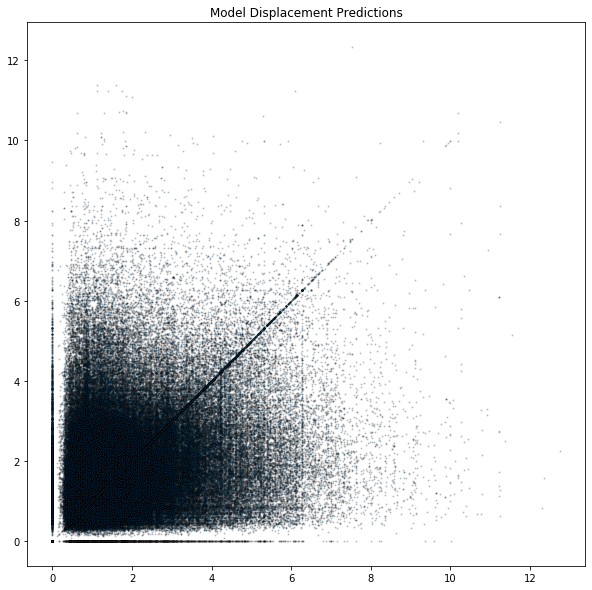

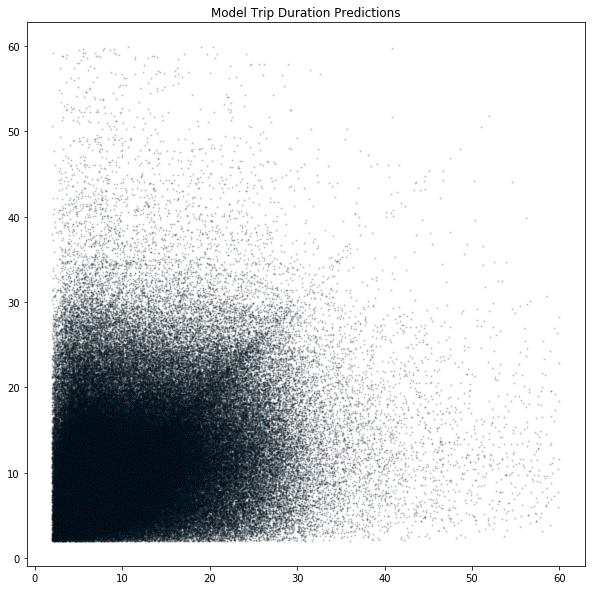

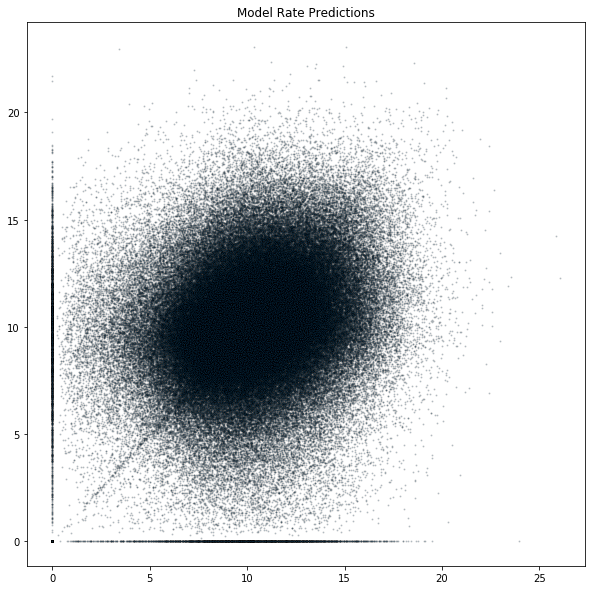

In [85]:
dist_actual = test_y_disp
dist_pred   = displacement_model.predict(test_X)

dur_actual  = test_y_dur
dur_pred    = duration_model.predict(test_X)

rate_actual = test_y_rate
rate_pred   = rate_model.predict(test_X)

fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(
    dist_actual, 
    dist_pred,
    s=1,
    alpha=0.2,
    edgecolor='k'
)
ax.set_title('Model Displacement Predictions')
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')

fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(
    dur_actual, 
    dur_pred,
    s=1,
    alpha=0.2,
    edgecolor='k'
)
ax.set_title('Model Trip Duration Predictions')
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')

fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(
    rate_actual, 
    rate_pred,
    s=1,
    alpha=0.2,
    edgecolor='k'
)
ax.set_title('Model Rate Predictions')
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')

plt.show()